<a href="https://colab.research.google.com/github/hankou-code/3_sem/blob/master/3_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Рабочий ноутбук для лабораторной работы 3.2.1 Сдвиг фаз в цепи переменного тока.

Данные были сняты с установки номер:

Дата выполнения работы: 2 октября 2021 года \\
Авторы работы: Ганьков Роман

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Вспомогательные функции

In [4]:
class DataHandler:
    def __init__(self, x, y, prefix=""):
        self.prefix = prefix
        self.x = x
        self.y = y
        self.n = x.size

    def computation_coefficients_with_lsm(self):
        # y = mx + c -----> y = Ap
        A = np.vstack([self.x, np.ones(len(self.x))]).T
        m, c = np.linalg.lstsq(A, self.y, rcond=None)[0]
        self.m = m
        self.c = c
    
    def computation_std_and_relative_error(self):
        # y_predicted was predicted with using the least squares method
        absolute_diff_y = self.y - self.m * self.x - self.c
        # standart deviation of y
        y_std = absolute_diff_y.std(axis=0, ddof=1)
        y_mean = self.y.mean()
        # relative error in determining the value of v [in percentes]
        y_relative = y_std / y_mean * 100
        self.y_std = y_std
        self.y_relative = y_relative

    def print_lsm_data(self):
        print(f"y = {self.m:.{3}}x + {self.c:.{3}}")
        print(f"std: {self.y_std:.{3}}")
        print(f"relative error: {self.y_relative:.{3}}%")

    def computation(self):
        self.computation_coefficients_with_lsm()
        self.computation_std_and_relative_error()
        self.computation_mean_square_error()
        self.predict_polynomial_function()

    def return_experimental_data_for_plotting(self, fmt='b-', label_name='Origin'):
        return [self.x, self.y, self.y_std, label_name, fmt]

    def return_lsm_for_plotting(self, fmt='r'):
        y = self.m * self.x + self.c
        
        # label_name = f"LSM predicted: [y={self.m:.{3}}*x + {self.c:.{3}}, std = {self.y_std:.{3}}, relative = {self.y_relative:.{3}}%] "
        label_name = f"LSM {self.prefix}: [y=({self.m:.{3}} +- {self.sigma_m:.{1}})*x + ({self.c:.{3}} +- {self.sigma_c:.{1}}"
        return [self.x, y, self.y_std, label_name, fmt]

    def return_polynomial_for_plotting(self, fmt='g'):
        y = self.polynomial_function(self.x)
        label_name = f" polynomial line {self.prefix} "
        # label_name = f" Polynom predicted: [{self.polynomial_function}]] "
        return [self.x, y, self.y_std, label_name, fmt]

    def return_lsm_coefs(self):
        return self.m, self.c

    def computation_mean_square_error(self):
        # D_xx, D_yy
        covariance_xx = np.average(np.square(self.x)) - np.square(np.average(self.x))
        covariance_yy = np.average(np.square(self.y)) - np.square(np.average(self.y))
        sigma_m_square = (1 / self.n - 2) * (covariance_yy / covariance_xx - np.square(self.m))
        sigma_c_square = sigma_m_square * np.average(np.square(self.x))
        self.sigma_m = np.sqrt(np.abs(sigma_m_square))
        self.sigma_c = np.sqrt(np.abs(sigma_c_square))


    def predict_polynomial_function(self, polynomial_order=7):
        polynomial_coefs = np.polyfit(self.x, self.y, polynomial_order)
        polynomial_function = np.poly1d(polynomial_coefs)
        self.polynomial_function = polynomial_function        



class DataVisualizer:
    def __init__(self, name_shedule="Test", images_dir='/content/gdrive/My Drive/phys_labs/', xlabel="", ylabel=""):
        self.name_shedule = name_shedule
        self.images_dir = images_dir
        self.num_lines = 0
        self.xlabel = xlabel
        self.ylabel = ylabel
        
    def add_line_to_graph(self, x, y, name, fmt, lsm_line = False, polynom_line = False, prefix=""):
        handler = DataHandler(x, y, prefix)
        handler.computation()

        curve = handler.return_experimental_data_for_plotting(label_name=name, fmt=fmt)
        lsm_curve = handler.return_lsm_for_plotting()
        polynom_curve = handler.return_polynomial_for_plotting()

        prepared_data = [curve]

        if (lsm_line):
            prepared_data = np.concatenate(([curve], [lsm_curve]), axis=0)

        if (polynom_line):
            prepared_data = np.concatenate(([curve], [polynom_curve]), axis=0)

        if self.num_lines == 0:
            self.data = prepared_data
        elif self.num_lines == 1:
            self.data = np.concatenate((self.data, prepared_data), axis=0)
        else:
            self.data = np.concatenate((self.data, prepared_data), axis=0)

        self.num_lines += 1
        
    # TODO: добавить возможность печати линии отдельно от графика
    def print_theoretically_calculated_dependence(self):
        pass

    def plot_lines(self):
        plt.figure(figsize=(15, 9))
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        for x, y, y_std, label_name, fmt in self.data:
            self.plot_line(x, y, y_std, label_name, fmt)
        self.save_plot()

    def plot_line(self, x, y, y_std, label_name, fmt='b', with_error_bar = False):
        plt.plot(x, y, fmt, label=label_name, markersize=2)
        if (with_error_bar):
            plt.errorbar(x, y, yerr=y_std, fmt=".")
        plt.legend()

    def save_plot(self):
        # saving image at google drive
        plt.savefig(f"{self.images_dir}/{self.name_shedule}.png", dpi = 300)

    # TODO: настроить отцентровку осей
    def axes_centralization(self):
        pass


Графики для RC цепи

In [10]:
R = np.array([0, 400, 800, 1200, 1600, 2000, 2400, 2800, 3200]) # сопротивление в Омах

r = 12 # там около 12 Ом было, мало в общем
pi = 3.14
C = 0.5 * 1.0e-6 # Ф
frequency = 1000 # Гц
omega = 2 * pi * frequency

delta_phi = np.array([0.0, 0.4, 0.7, 1.1, 1.4, 1.7, 2.0, 2.2, 2.4]) # отклонение от начальной позиции в клетках, в меньшую сторону
phi_0 = 5 # начальное отклонение в клетках, соответствует разнице фаз в pi/2
phi_0_radian = pi / 2

delta = phi_0 - delta_phi # разница фаз в клетках
delta_radians = (delta / phi_0) * phi_0_radian # например 4.6 клеток делим на 5 клеток и умножаем на pi/2

varphi = delta_radians

R_sum = R + r 

x = omega * C * R_sum
y = np.cos(varphi) / np.sin(varphi)

xlabel = "w*C*R_sum"
ylabel = "ctg(varphi)"

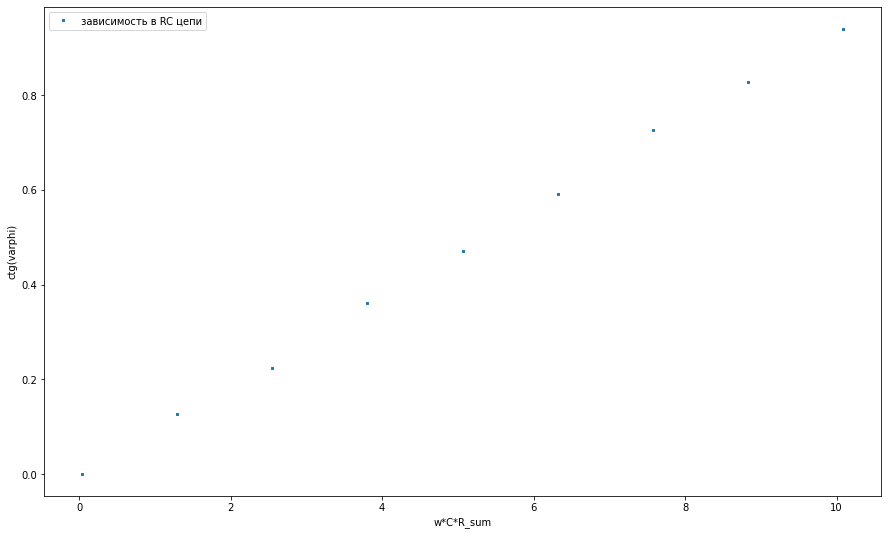

In [13]:
dv = DataVisualizer(name_shedule="RC", xlabel = xlabel, ylabel=ylabel)
dv.add_line_to_graph(x=x, y=y, name="зависимость в RC цепи", fmt="s")
dv.plot_lines()

RL цепь

In [23]:
R = np.array([0, 400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 4200, 5200, 6200, 7200, 8200, 9200, 10000]) # сопротивление в Омах

r = 12 # там около 12 Ом было, мало в общем
pi = 3.14
L = 50 * 1.0e-3
frequency = 1000 # Гц
omega = 2 * pi * frequency
R_L = omega * L

delta_phi = np.array([1.2, 1.0, 0.9, 0.8, 0.8, 0.7, 0.6, 0.6, 0.5, 0.4, 0.3, 0.3, 0.2, 0.2, 0.2, 0.1]) # разница фаз в клетках
phi_0 = 1.2 # начальное отклонение в клетках, соответствует разнице фаз в pi/2
phi_0_radian = pi / 2

delta_radians = (delta_phi / phi_0) * phi_0_radian # например 1.0 клеток делим на 1.2 клетки и умножаем на pi/2

varphi = delta_radians

R_sum = R + r + R_L

x = R_sum / (omega * L)
y = np.cos(varphi) / np.sin(varphi)
xlabel = "R_sum / (omega * L)"
ylabel = "ctg(varphi)"

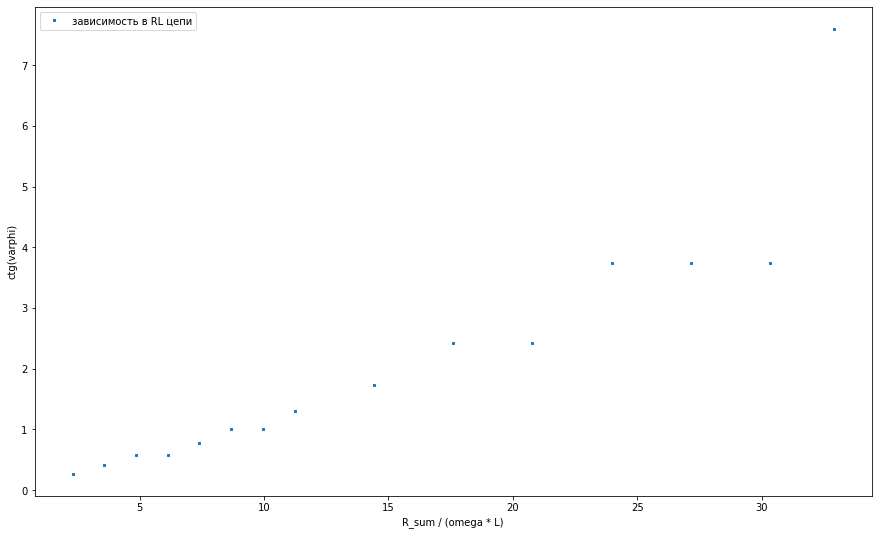

In [22]:
dv = DataVisualizer(name_shedule="RL", xlabel = xlabel, ylabel=ylabel)
dv.add_line_to_graph(x=x, y=y, name="зависимость в RL цепи", fmt="s")
dv.plot_lines()

RCL цепь

In [ ]:
x = np.array([-0.8, -1.2, -0.8, -0.2, -0.1, 0.0, 0.2, 0.4, 0.6, 0.7, 0.7, 0.6, 0.6])
x_0 = np.array([2.6, 5.0, 8.5, 6.4, 5.6, 1.0, 9.3, 7.3, 5.7, 4.1, 3.0, 2.0, 1.8])
pi = 3.14
delta_phi = (x / x_0) * pi

frequency  = np.array([100, 200, 600, 800, 900, 1000, 1100, 1400, 1800, 2500, 3500, 5000, 6000]) # Гц

x = frequency
y = delta_phi

xlabel = "частота в герцах"
ylabel = "отклонение в радианах"

In [ ]:
dh = DataVisualizer(name_shedule="3.2.1", xlabel=xlabel, ylabel=ylabel)
dh.add_line_to_graph(x=x, y=y, name="Измеренная зависимость вверх", fmt='s')

dh.plot_lines()